<a href="https://colab.research.google.com/github/arumajirou/ETNA/blob/main/backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# バックテスト：過去データでの検証

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/backtest.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

このノートブックには、ETNAライブラリのバックテストモジュールを使用した時系列検証の簡単な例が含まれています。

- 目次

 - バックテストとは何か、どのように機能するか
 - バリデーションの実行方法
 - FoldMaskを使ったバックテスト
 - バリデーションビジュアライゼーション
 - メトリクスの可視化

In [9]:
!pip install --upgrade pip
!pip install etna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.metrics import MSE
from etna.metrics import SMAPE
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.analysis.plotters import plot_backtest

### **1.バックテストとは何か、どのように機能するか**

- バックテストは、過去のデータを基にした予測と検証のパイプラインで、モデルの正当なレトロテストを行うことができます。

- どのように機能するのですか？

- モデルを用いて予測を構築し、さらに予測指標を評価する場合、テストと呼ばれるある時間間隔での品質を測定する。

- バックテストは、モデルが過去にどのように機能するかをシミュレートすることができます。

 - 過去のものを選択します。

 - 選択された区間をトレーニングサンプルとしてモデルを構築する

 - テスト間隔での値を予測し、メトリックスを計算します。

画像は、n_folds = 3でバックテストパイプラインをプロットしたものです。
<img src="https://etna-docs.netlify.app/_images/tutorials_backtest_5_0.png">

In [11]:
csv_path ="https://github.com/tinkoff-ai/etna/raw/master/examples/data/example_dataset.csv"
df = pd.read_csv(csv_path)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.loc[df.segment == "segment_a"]
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279



- 本ライブラリは、空間データ構造TSDatasetで動作します。
- そこで、EDAを始める前に、古典的なDataFrameをTSDatasetに変換する必要があります。

In [12]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

### **シリーズで見てみよう**

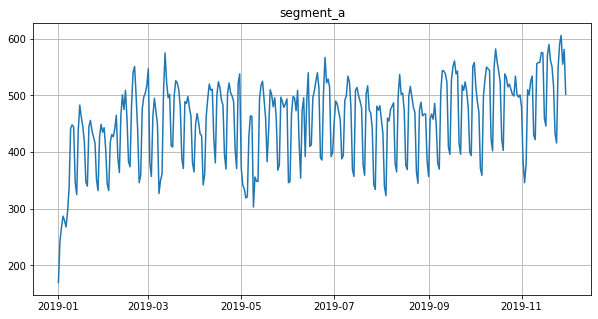

In [13]:
ts.plot(segments=["segment_a"])

### **2.バリデーションの実行方法**

まず、Prophetのモデルを作ってみましょう。

In [44]:
horizon = 31  # 予測の地平線を設定
model = ProphetModel()  # モデルの作成
transforms = []  #トランスフォームのリスト - いずれも使用しません。

### **パイプライン**

では、Pipelineのインスタンスを作ってみましょう。

In [46]:
#最終的な推定量による変換のパイプライン。
#指定されたパラメータを持つPipelineのインスタンスを作成します。
pipeline = Pipeline(model=model,# -etnaモデルのインスタンスです。
                    transforms=transforms,# トランスフォームのシーケンス．
                    horizon=horizon)#-予測のための、未来におけるタイムスタンプの数
pipeline

Pipeline(model = ProphetModel(growth = 'linear', changepoints = None, n_changepoints = 25, changepoint_range = 0.8, yearly_seasonality = 'auto', weekly_seasonality = 'auto', daily_seasonality = 'auto', holidays = None, seasonality_mode = 'additive', seasonality_prior_scale = 10.0, holidays_prior_scale = 10.0, changepoint_prior_scale = 0.05, mcmc_samples = 0, interval_width = 0.8, uncertainty_samples = 1000, stan_backend = None, additional_seasonality_params = (), ), transforms = [], horizon = 31, )

そのためのバックテスト・メソッドを実行します。

その結果、3つのデータフレームが返されます。

- 各フォールドと各セグメントに対するメトリックスを含むデータフレーム。
- データフレームに予測値を格納します。
- 折り目に関する情報を含むデータフレーム。

In [51]:
#パイプラインで バックテストを実行します。
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts, #バックテストでモデルを適合させるデータセット
                                                          #各フォールドに対して計算するメトリクスのリストです。
                                                          metrics=[MAE(),#マルチセグメント計算をサポートしたMean Absolute Error Metric
                                                                   MSE(),#マルチセグメント計算をサポートした平均二乗誤差測定法。
                                                                   SMAPE()#マルチセグメント計算をサポートする対称的な平均絶対パーセンテージエラー測定法。
                                                                   ])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/i3fmuy31.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/pt4yj9wc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24749', 'data', 'file=/tmp/tmp4bpa2j9v/i3fmuy31.json', 'init=/tmp/tmp4bpa2j9v/pt4yj9wc.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_modelfdnjn_ks/prophet_model-20221225124651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:46:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:46:51 - cmdstanpy - INFO - Chain [1] done processing
I

In [52]:
metrics_df.head()

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,18.877607,597.469007,4.378189,0
0,segment_a,21.025154,673.137874,4.842466,1
0,segment_a,30.502645,1349.297219,6.391026,2
0,segment_a,35.950494,1995.343975,7.416735,3
0,segment_a,32.455953,1898.134390,6.556820,4


In [53]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.363413
2019-06-30           0  386.284295
2019-07-01           0  493.226942
2019-07-02           0  509.639340
2019-07-03           0  497.807373

In [54]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


さらに、フォールド数で平均化された指標を得ることができます。

In [55]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts,
    metrics=[MAE(),
             MSE(),
             SMAPE()],
              aggregate_metrics=True#True の場合、フォルドの上にメトリクスを集約し、そうでない場合は生のメトリクスを返す。
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/egq8iu1r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/6rr_ge2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49820', 'data', 'file=/tmp/tmp4bpa2j9v/egq8iu1r.json', 'init=/tmp/tmp4bpa2j9v/6rr_ge2u.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_model85rttpvx/prophet_model-20221225124830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:48:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:30 - cmdstanpy - INFO - Chain [1] done processing
I

In [56]:
metrics_df.head()

,segment,MAE,MSE,SMAPE
0,segment_a,27.762371,1302.676493,5.917047


In [57]:
forecast_df.head()

segment      segment_a            
feature    fold_number      target
timestamp                         
2019-06-29           0  395.363413
2019-06-30           0  386.284295
2019-07-01           0  493.226942
2019-07-02           0  509.639340
2019-07-03           0  497.807373

In [58]:
fold_info_df.head()

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2019-01-01,2019-06-28,2019-06-29,2019-07-29,0
0,2019-01-01,2019-07-29,2019-07-30,2019-08-29,1
0,2019-01-01,2019-08-29,2019-08-30,2019-09-29,2
0,2019-01-01,2019-09-29,2019-09-30,2019-10-30,3
0,2019-01-01,2019-10-30,2019-10-31,2019-11-30,4


### **3.フォールドマスクによるバックテスト**

- FoldMask を使って、バックテスト用のストラテジーを使用することができます

 - FoldMask を作成するには、
     - first_train_timestamp,
     - last_train_timestamp,
     - target_timestamps 
 - を指定する必要があります。
 - そして、pipeline.backtest にn_foldsパラメータとして、マスクのリストを渡す必要があります。

- Sktimeの
     -  SlidingWindowSplitter、
     - ExpandingWindowSplitter、
     - SingleWindowSplitter
- に似た3つのストラテジーを考えてみましょう。

### **エキスパンドウィンドウスプリッター**
このバックテスト戦略では、mode="expand "のバックテストを使用することができます。

In [59]:
metrics_df, _, _ = pipeline.backtest(ts=ts,#バックテストでモデルを適合させるデータセット
                                     #各フォールドに対して計算するメトリクスのリストです。
                                     metrics=[MAE(),
                                              MSE(),
                                              SMAPE()],
                                     n_folds=3, # フォールド数、またはフォールドマスクのリスト
                                     mode="expand")#訓練生成の方針，n_folds がマスクのリストの場合は無視されます．(expand =拡張)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/2qgph849.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/wjoe91je.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3634', 'data', 'file=/tmp/tmp4bpa2j9v/2qgph849.json', 'init=/tmp/tmp4bpa2j9v/wjoe91je.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_modelbkxh1bbh/prophet_model-20221225125053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:50:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:50:53 - cmdstanpy - INFO - Chain [1] done processing
IN

In [60]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,30.502645,1349.297219,6.391026,0
0,segment_a,35.950494,1995.343975,7.416735,1
0,segment_a,32.455953,1898.134390,6.556820,2


### **SingleWindowSplitter**

- このバックテスト戦略では、n_folds=1のパラメータで我々のバックテストを使用することができますし、
- データセットから特定のウィンドウが必要な場合は、FoldMaskでマスクを作成することができます。

In [61]:
#フォールドマスクは、バックテスト戦略のカスタマイズに使用されることが期待されます。
from etna.pipeline import FoldMask
import numpy as np

In [62]:
# 1 マスクなし

metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=1)
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/1a6726g3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/8qo3ssth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3452', 'data', 'file=/tmp/tmp4bpa2j9v/1a6726g3.json', 'init=/tmp/tmp4bpa2j9v/8qo3ssth.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_modelmxch7tzz/prophet_model-20221225125138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:51:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:51:38 - cmdstanpy - INFO - Chain [1] done processing
IN

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,32.455953,1898.13439,6.55682,0


In [64]:
# 2 特定のマスクを使用した場合
window_size = 85
first_train_timestamp = ts.index.min() + np.timedelta64(100, "D")
last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
mask = FoldMask(
    first_train_timestamp=first_train_timestamp,#最初の訓練タイムスタンプ
    last_train_timestamp=last_train_timestamp,#最後の訓練タイムスタンプ
    target_timestamps=target_timestamps,#対象タイムスタンプのリスト
)

In [29]:
# 1 マスクなし

metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=[mask])
metrics_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/uqg4b6_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/x00nufwe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10546', 'data', 'file=/tmp/tmp4bpa2j9v/uqg4b6_u.json', 'init=/tmp/tmp4bpa2j9v/x00nufwe.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_model1oc1t2_u/prophet_model-20221225121750.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:17:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:50 - cmdstanpy - INFO - Chain [1] done processing


,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,39.782294,2191.914481,9.056343,0


### **スライディングウィンドウスプリッター**

このバックテスト戦略を実行するには、FoldMask を使用してフォールドマスクのリストを作成する必要があります。

In [30]:
n_folds = 3

In [65]:
def sliding_window_masks(window_size, n_folds):
    masks = []
    for n in range(n_folds):
        first_train_timestamp = ts.index.min() + np.timedelta64(100, "D") + np.timedelta64(n, "D")
        last_train_timestamp = first_train_timestamp + np.timedelta64(window_size, "D")
        target_timestamps = pd.date_range(start=last_train_timestamp + np.timedelta64(1, "D"), periods=horizon)
        mask = FoldMask(
            first_train_timestamp=first_train_timestamp,#最初の訓練タイムスタンプ
            last_train_timestamp=last_train_timestamp,#最後の訓練タイムスタンプ
            target_timestamps=target_timestamps,#対象タイムスタンプのリスト
        )
        masks.append(mask)
    return masks

In [66]:
masks = sliding_window_masks(window_size=window_size, n_folds=n_folds)
metrics_df, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), MSE(), SMAPE()], n_folds=masks)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/ogp4vlcy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/9mvct0mt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73669', 'data', 'file=/tmp/tmp4bpa2j9v/ogp4vlcy.json', 'init=/tmp/tmp4bpa2j9v/9mvct0mt.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_model84artabf/prophet_model-20221225125337.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:53:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:53:38 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,segment_a,39.782294,2191.914481,9.056343,0
0,segment_a,40.293273,2287.327211,9.108208,1
0,segment_a,39.861538,2192.546365,9.010128,2


4.バリデーションビジュアライゼーション

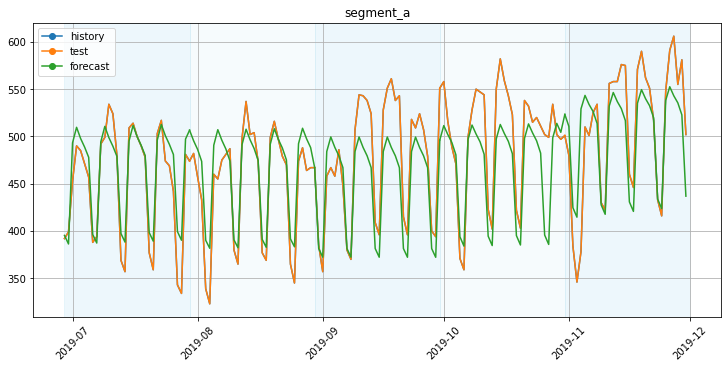

In [69]:
#バックテスト・パイプラインのターゲットと予測をプロットします
plot_backtest(forecast_df, #時系列データで予測したデータフレーム
              ts)#バックテストに使用されたタイムスリリーのデータフレーム

訓練部分を可視化するために、history_lenパラメータを指定することができます。

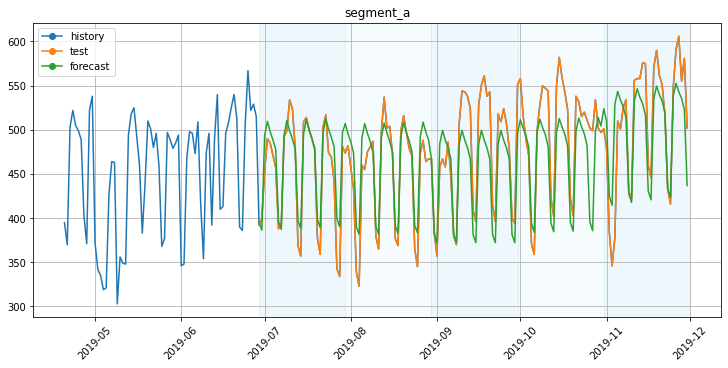

In [70]:
#バックテスト・パイプラインのターゲットと予測をプロットします
plot_backtest(forecast_df,#時系列データで予測したデータフレーム
              ts,#バックテストに使用されたタイムスリリーのデータフレーム
              history_len=70)#プロットするバックテスト前のヒストリーの長さ。

### **5.メトリクスの可視化**

このセクションでは、バックテスト結果を様々な視点から分析します。

In [36]:
from etna.analysis import (
    metric_per_segment_distribution_plot,#セグメントごとのメトリクスの分布図。
    plot_residuals,#バックテストによる予測値の残差を、ある特徴量に対してプロットする。
    plot_metric_per_segment,#セグメントごとの指標を示すバープロット。
    prediction_actual_scatter_plot,#セグメントの予測値/実測値の散布図。
)

In [38]:

df = pd.read_csv(csv_path)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = TSDataset.to_dataset(df)
ts_all = TSDataset(df, freq="D")

In [39]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(ts=ts_all, metrics=[MAE(), MSE(), SMAPE()])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/s5e_1sh2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bpa2j9v/2kpt2tob.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43271', 'data', 'file=/tmp/tmp4bpa2j9v/s5e_1sh2.json', 'init=/tmp/tmp4bpa2j9v/2kpt2tob.json', 'output', 'file=/tmp/tmp4bpa2j9v/prophet_model1qs_j7vh/prophet_model-20221225121852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:18:52 - cmdstanpy - INFO - Chain [1] done processing
I

- SMAPE メトリクスの倍率による分布を見てみましょう。
- type_plotにはbox,violin,hist のいずれかを指定します。

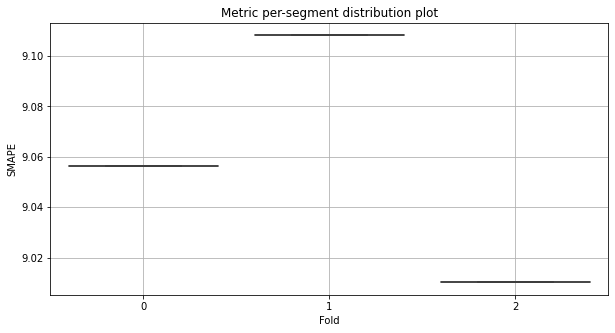

In [71]:
#@title セグメントごとのメトリクスの分布図。
metric_per_segment_distribution_plot(metrics_df=metrics_df,#バックテストで計算されたメトリクスを含むデータフレーム
                                     metric_name="SMAPE",#表示される指標の名前
                                     plot_type="box")#プロットの種類

SMAPEの指標をセグメント別に見てみましょう。

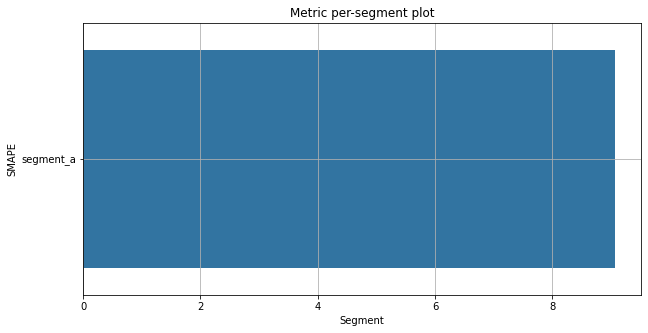

In [72]:
#@title セグメントごとの指標をバープロットしたもの
plot_metric_per_segment(metrics_df=metrics_df,#バックテストで計算されたメトリクスを含むデータフレーム
                        metric_name="SMAPE",#表示される指標の名前で
                        ascending=True)#Trueの場合、上部に小さな値を表示します。

- ここで、バックテストによるモデルの予測値の残差を見てみましょう。
残差の分析は、モデルが見つけられなかったデータ中の依存関係を確立するのに役立ちます。
- このようにして、機能を追加したり、モデルを改善したり、残差に依存性がないことを確認することができます。
- また、残差はタイムスタンプだけでなく、任意の特徴によって可視化することができます。

KeyError: ignored

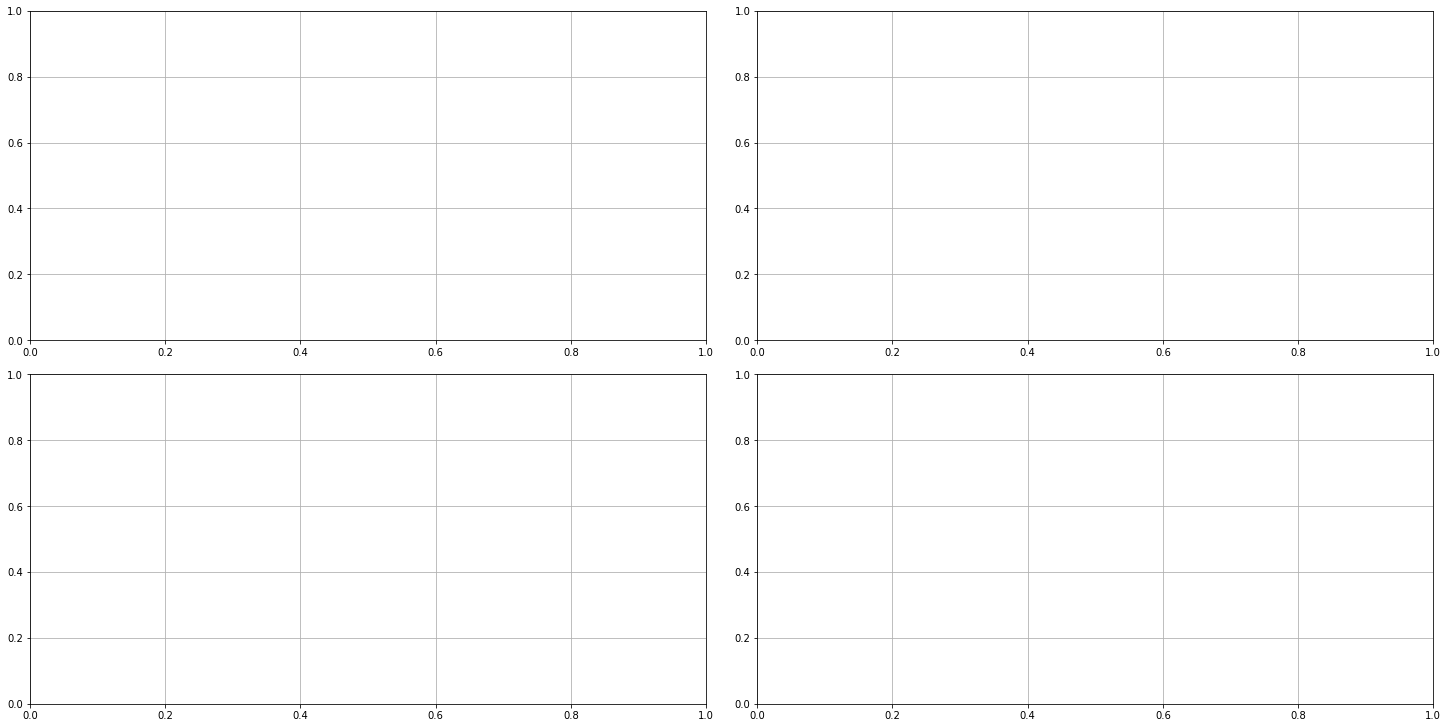

In [73]:
#@title バックテストによる予測値の残差を、ある特徴量に対してプロットする。
plot_residuals(forecast_df=forecast_df, #時系列データで予測したデータフレーム
               ts=ts_all)#バックテストに使用されたタイムスケールのデータフレーム．

KeyError: ignored

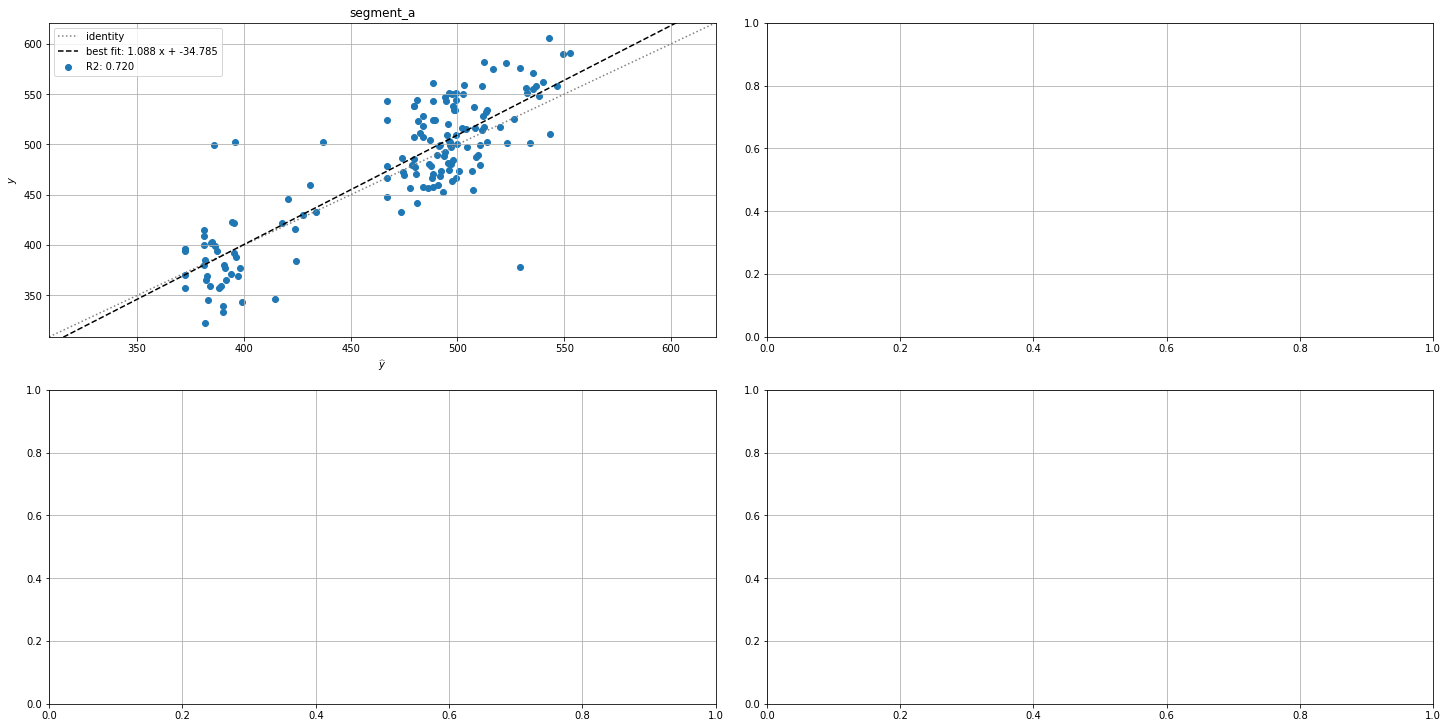

In [74]:
#@title セグメントの予測値/実測値の散布図。
prediction_actual_scatter_plot(forecast_df=forecast_df,#時系列データで予測したデータフレーム
                               ts=ts_all)#バックテストに使用されたタイムスリリーのデータフレーム

このノートブックについては以上です。その他の機能はドキュメントをご覧ください。